In [96]:
!python -m pip install sqlalchemy

!pip install tabulate
!pip install pandas


In [97]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd

In [100]:
with engine.connect() as conn:
    df = pd.read_sql("SELECT * FROM imdb_movies", conn)
print(df)

        id                             title  duration  rating  voters  \
0     5048              Mi Ilustrísimo Amigo      80.0     9.8    60.0   
1     7320                     Dheera Samrat     123.0     9.7  1000.0   
2     7135           Faction Leni Seemakatha      95.0     9.7   540.0   
3     4131                    Tears of Blood      88.0     9.7    80.0   
4     6790                        31st Movie     145.0     9.6   190.0   
...    ...                               ...       ...     ...     ...   
5791  2325  Amityville: Where the Echo Lives      89.0     1.5  4740.0   
5792   805                            Daanvi     117.0     1.5    90.0   
5793  6978                      Q: Deep Fake      60.0     1.4   140.0   
5794  2928                          Cin Köyü      75.0     1.0   150.0   
5795  4959  PAPmusic - Animation for Fashion      85.0     1.0  2080.0   

         genre  
0      Romance  
1     Thriller  
2     Thriller  
3      Mystery  
4     Thriller  
...      

In [99]:


# --- TiDB Connection Details ---
user = "2JRRhPHCS6mRsGW.root"
password = "mt2YyedoEbMz4suV"
host = "gateway01.ap-southeast-1.prod.aws.tidbcloud.com"
port = 4000

# Step 1: Connect without selecting a database
conn = pymysql.connect(
    host=host,
    user=user,
    password=password,
    port=port,
    ssl={"ssl_verify_cert": True, "ssl_verify_identity": True}
)

cur = conn.cursor()
cur.execute("CREATE DATABASE IF NOT EXISTS imdb;")
print("✅ Database `imdb` created (or already exists).")

cur.close()
conn.close()


✅ Database `imdb` created (or already exists).


In [101]:


database = "imdb"

engine = create_engine(
    f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}",
    connect_args={
        "ssl": {
            "ssl_verify_cert": True,
            "ssl_verify_identity": True
        }
    }
)

# Save DataFrame to TiDB
df.to_sql(
    "imdb_movies",
    con=engine,
    if_exists="replace",
    index=False
)

print("🎉 DataFrame stored in TiDB -> imdb.imdb_movies")


🎉 DataFrame stored in TiDB -> imdb.imdb_movies


In [102]:
# --- Query Data back into Pandas ---
from tabulate import tabulate

df_movies = pd.read_sql("SELECT * FROM imdb_movies LIMIT 20;", engine)

# --- Display as Table using tabulate ---
print(tabulate(df_movies, headers="keys", tablefmt="psql", showindex=False))

+------+-------------------------------+------------+----------+----------+-----------+
|   id | title                         |   duration |   rating |   voters | genre     |
|------+-------------------------------+------------+----------+----------+-----------|
| 5048 | Mi Ilustrísimo Amigo          |         80 |      9.8 |       60 | Romance   |
| 7320 | Dheera Samrat                 |        123 |      9.7 |     1000 | Thriller  |
| 7135 | Faction Leni Seemakatha       |         95 |      9.7 |      540 | Thriller  |
| 4131 | Tears of Blood                |         88 |      9.7 |       80 | Mystery   |
| 6790 | 31st Movie                    |        145 |      9.6 |      190 | Thriller  |
|  666 | Bolice                        |        102 |      9.6 |       50 | Action    |
| 4298 | American Dirge                |         81 |      9.6 |       50 | Mystery   |
| 4989 | Ram Bharosey                  |         95 |      9.6 |      410 | Romance   |
| 7599 | Lorii                  

In [103]:
#1.Top 10 Movies by Rating and Voting Counts
from tabulate import tabulate

query = """
SELECT title, rating, voters
FROM imdb_movies
WHERE rating IS NOT NULL AND voters IS NOT NULL
ORDER BY voters DESC, rating DESC
LIMIT 10;
"""

# use a fresh connection so you don’t hit PendingRollbackError
with engine.connect() as conn:
    df_sorted = pd.read_sql(query, conn)

print(tabulate(df_sorted, headers="keys", tablefmt="psql", showindex=False))


+-------------------------+----------+----------+
| title                   |   rating |   voters |
|-------------------------+----------+----------|
| Dune: Part Two          |      8.5 | 6.6e+06  |
| Deadpool & Wolverine    |      7.5 | 5.23e+06 |
| The Substance           |      7.2 | 3.33e+06 |
| Furiosa: A Mad Max Saga |      7.5 | 2.99e+06 |
| Gladiator II            |      6.5 | 2.7e+06  |
| Alien: Romulus          |      7.1 | 2.63e+06 |
| Civil War               |      7   | 2.5e+06  |
| The Fall Guy            |      6.8 | 2.33e+06 |
| Inside Out 2            |      7.5 | 2.29e+06 |
| Nosferatu               |      7.2 | 2.28e+06 |
+-------------------------+----------+----------+


In [104]:
#2.Genre Distribution

from tabulate import tabulate
import pandas as pd

query = """
SELECT genre, COUNT(*) AS movie_count
FROM imdb_movies
WHERE genre IS NOT NULL
GROUP BY genre
ORDER BY movie_count DESC;
"""

# use a fresh connection
with engine.connect() as conn:
    df_genre = pd.read_sql(query, conn)

print(tabulate(df_genre, headers="keys", tablefmt="psql", showindex=False))


+-----------+---------------+
| genre     |   movie_count |
|-----------+---------------|
| Thriller  |          1569 |
| Horror    |          1367 |
| Romance   |          1055 |
| Action    |          1009 |
| Adventure |           425 |
| Mystery   |           371 |
+-----------+---------------+


In [105]:
#3.Average Movie Duration by Genre
from tabulate import tabulate
import pandas as pd

query = """
SELECT genre, ROUND(AVG(duration), 2) AS avg_duration
FROM imdb_movies
WHERE genre IS NOT NULL AND duration IS NOT NULL
GROUP BY genre
ORDER BY avg_duration DESC;
"""

with engine.connect() as conn:
    df_duration = pd.read_sql(query, conn)

print(tabulate(df_duration , headers="keys", tablefmt="psql", showindex=False))



+-----------+----------------+
| genre     |   avg_duration |
|-----------+----------------|
| Romance   |         103.75 |
| Action    |         103.6  |
| Thriller  |         100.49 |
| Mystery   |          99.18 |
| Adventure |          96.92 |
| Horror    |          93.47 |
+-----------+----------------+


In [106]:
#4.Voting Trends by Genre
import pandas as pd
from sqlalchemy import create_engine



query = """
SELECT genre, AVG(voters) AS avg_voters
FROM imdb_movies
WHERE genre IS NOT NULL AND voters IS NOT NULL
GROUP BY genre
ORDER BY avg_voters DESC;
"""

with engine.connect() as conn:
    df_votes = pd.read_sql(query, conn)
print(tabulate(df_votes , headers="keys", tablefmt="psql", showindex=False))


+-----------+--------------+
| genre     |   avg_voters |
|-----------+--------------|
| Adventure |     109317   |
| Action    |      71596.8 |
| Thriller  |      55033.9 |
| Mystery   |      50075.8 |
| Romance   |      43040.5 |
| Horror    |      35803.6 |
+-----------+--------------+


In [107]:
!pip install matplotlib seaborn
!pip install plotly as px
!pip install nbformat


ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as


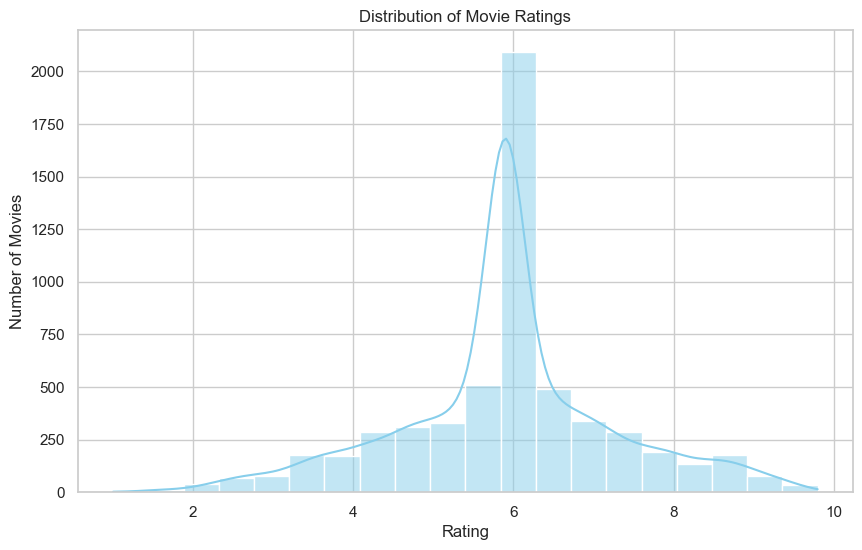

In [108]:
#5.Rating Distribution Visualization


df_ratings = df[['rating']].dropna()

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(10,6))
sns.histplot(df_ratings['rating'], bins=20, kde=True, color='skyblue')
plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Number of Movies")
plt.show()



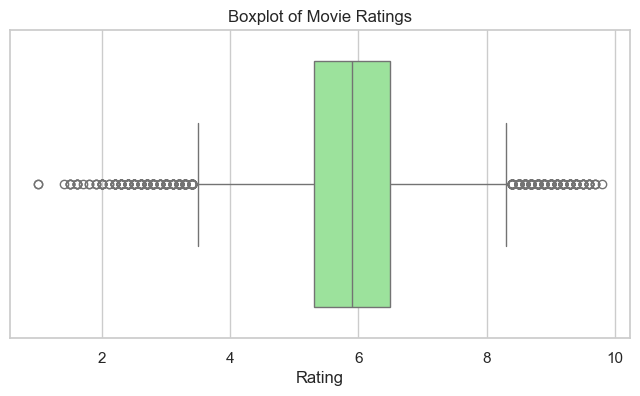

In [109]:
plt.figure(figsize=(8,4))
sns.boxplot(x=df_ratings['rating'], color='lightgreen')
plt.title("Boxplot of Movie Ratings")
plt.xlabel("Rating")
plt.show()


In [120]:


#6.Genre-Based Rating Leaders

query = """
SELECT genre, title, rating, voters
FROM imdb_movies
WHERE genre IS NOT NULL AND rating IS NOT NULL
ORDER BY genre, voters DESC, rating DESC;
"""

with engine.connect() as conn:
    df_movies = pd.read_sql(query, conn)

# Sort by genre, rating descending, voters descending
df_sorted = df_movies.sort_values(['genre', 'voters', 'rating'], ascending=[True, False, False])

# Keep only the top-rated movie per genre
df_top_per_genre = df_sorted.groupby('genre', as_index=False).first()

# Display table like your example
print(tabulate(df_top_per_genre, headers="keys", tablefmt="psql", showindex=False))



+-----------+----------------+----------+----------+
| genre     | title          |   rating |   voters |
|-----------+----------------+----------+----------|
| Action    | Gladiator II   |      6.5 | 2.7e+06  |
| Adventure | Dune: Part Two |      8.5 | 6.6e+06  |
| Horror    | The Substance  |      7.2 | 3.33e+06 |
| Mystery   | Blink Twice    |      6.5 | 1.16e+06 |
| Romance   | Anora          |      7.4 | 2.21e+06 |
| Thriller  | Civil War      |      7   | 2.5e+06  |
+-----------+----------------+----------+----------+


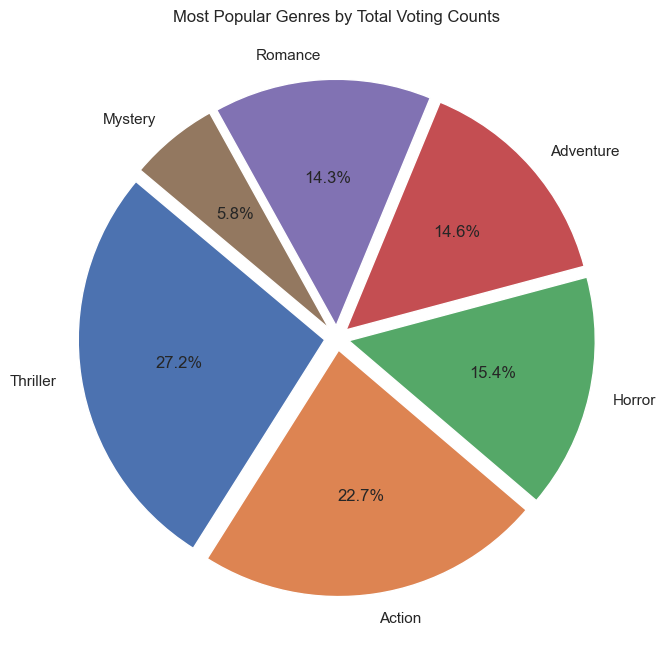

In [121]:
#7.Most Popular Genres by Voting Counts
# Fetch data from your database
query = """
SELECT genre, voters
FROM imdb_movies
WHERE genre IS NOT NULL AND voters IS NOT NULL;
"""

with engine.connect() as conn:
    df = pd.read_sql(query, conn)


# Aggregate total voters per genre
genre_votes = df.groupby('genre')['voters'].sum().sort_values(ascending=False)

# Plot pie chart
plt.figure(figsize=(8,8))
plt.pie(genre_votes, labels=genre_votes.index, autopct='%1.1f%%', startangle=140, explode=[0.05]*len(genre_votes))
plt.title("Most Popular Genres by Total Voting Counts")
plt.show()

In [122]:
#8.Duration Extremes
with engine.connect() as conn:
    # Shortest 5 movies
    df_shortest = pd.read_sql("""
        SELECT 'Shortest' AS type, title, genre, duration
        FROM imdb_movies
        WHERE duration IS NOT NULL
        ORDER BY duration ASC
        LIMIT 5;
    """, conn)

    # Longest 5 movies
    df_longest = pd.read_sql("""
        SELECT 'Longest' AS type, title, genre, duration
        FROM imdb_movies
        WHERE duration IS NOT NULL
        ORDER BY duration DESC
        LIMIT 5;
    """, conn)

# Combine both
df_duration_extremes = pd.concat([df_shortest, df_longest], ignore_index=True)

# Display
from tabulate import tabulate
print(tabulate(df_duration_extremes, headers="keys", tablefmt="psql", showindex=False))


+----------+--------------------------------------------------------------------+-----------+------------+
| type     | title                                                              | genre     |   duration |
|----------+--------------------------------------------------------------------+-----------+------------|
| Shortest | Sugar Mami                                                         | Thriller  |         60 |
| Shortest | PW V: Tears of the Fallen                                          | Adventure |         60 |
| Shortest | Colegio Girassol                                                   | Romance   |         60 |
| Shortest | Cholay                                                             | Romance   |         60 |
| Shortest | Love Across Time                                                   | Romance   |         60 |
| Longest  | Pedazo del Alma                                                    | Action    |        540 |
| Longest  | In Search of Darkness 19

+-----------+----------+
| genre     |   rating |
|-----------+----------|
| Action    |  6.0222  |
| Adventure |  5.95671 |
| Horror    |  5.45011 |
| Mystery   |  6.08383 |
| Romance   |  6.17886 |
| Thriller  |  5.98961 |
+-----------+----------+


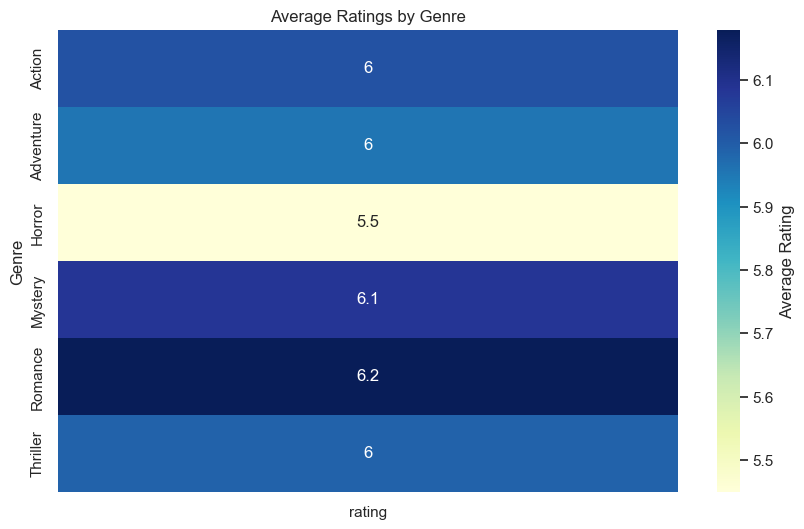

In [125]:
#9.Heatmap of Ratings by Genre



# Fetch data
query = """
SELECT genre, rating
FROM imdb_movies
WHERE genre IS NOT NULL AND rating IS NOT NULL;
"""

with engine.connect() as conn:
    df = pd.read_sql(query, conn)

# Compute average rating per genre
avg_ratings = df.groupby('genre')['rating'].mean().reset_index()
# Display
from tabulate import tabulate
print(tabulate(avg_ratings, headers="keys", tablefmt="psql", showindex=False))



# Convert to a format suitable for heatmap (genre as index)
heatmap_data = avg_ratings.pivot_table(index='genre', values='rating')

# Plot
plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Average Rating'})
plt.title("Average Ratings by Genre")
plt.ylabel("Genre")
plt.xlabel("")
plt.show()



+----------+---------------+
|   rating |        voters |
|----------+---------------|
|      9.8 |     60        |
|      9.7 |   1000        |
|      9.7 |    540        |
|      9.7 |     80        |
|      9.6 |    190        |
|      9.6 |     50        |
|      9.6 |     50        |
|      9.6 |    410        |
|      9.6 |     80        |
|      9.6 |    130        |
|      9.6 |    610        |
|      9.5 |    410        |
|      9.5 |    110        |
|      9.5 |    220        |
|      9.5 |    260        |
|      9.5 |    130        |
|      9.5 |    250        |
|      9.5 |     90        |
|      9.4 |     50        |
|      9.4 |     90        |
|      9.4 |    530        |
|      9.4 |   1360        |
|      9.4 |    860        |
|      9.4 |    520        |
|      9.4 |    170        |
|      9.4 |    220        |
|      9.4 |     80        |
|      9.4 |    130        |
|      9.4 |    610        |
|      9.4 |    380        |
|      9.4 |  10000        |
|      9.4 |  

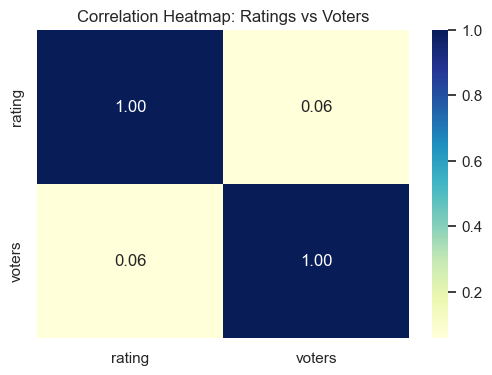

Pearson correlation between rating and voters: 0.06


In [126]:


#10.Correlation between Ratings and Voting Counts

# Fetch data from your database

query = """
SELECT rating, voters
FROM imdb_movies
WHERE rating IS NOT NULL AND voters IS NOT NULL;
"""

with engine.connect() as conn:
    df = pd.read_sql(query, conn)

# Display
from tabulate import tabulate
print(tabulate(df, headers="keys", tablefmt="psql", showindex=False))

# ---- Heatmap for correlation ----
import matplotlib.pyplot as plt
import seaborn as sns

corr = df.corr(numeric_only=True)

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="YlGnBu", fmt=".2f", cbar=True)

plt.title("Correlation Heatmap: Ratings vs Voters")
plt.show()

# Optional: also print correlation value
correlation = df['rating'].corr(df['voters'])
print(f"Pearson correlation between rating and voters: {correlation:.2f}")

